# Parallel Computing

## Generalidades

In [2]:
from IPython import parallel 
engines = parallel .Client () 
engines.block = True 
engines.ids


[0, 1, 2, 3]

In [3]:
engines[0].execute('a = 2' )
engines[0].execute('b = 10')
engines[0].execute('c = a + b')

<AsyncResult: execute:finished>

In [4]:
engines[0].pull('c')


12

In [5]:
engines[0].execute('a = 2') 
engines[0].execute('b = 10') 
engines[1].execute('a = 9' ) 
engines[1].execute('b = 7' ) 
engines[0:2].execute('c = a + b')

<AsyncResult: execute:finished>

In [6]:
engines[0:2].pull('c')

[12, 16]

## 150 millones de dígitos de pi

In [7]:
import matplotlib.pyplot as plt
import sympy
import numpy as np

pi = sympy.pi.evalf(40)
pi

3.141592653589793238462643383279502884197

### Metodos utiles

In [8]:
# https://github.com/jupyter-attic/ipython-py3k/blob/master/docs/examples/newparallel/pidigits.py

def fetch_pi_file(filename):
    """This will download a segment of pi from super-computing.org
    if the file is not already present.
    """
    import os, urllib.request, urllib.parse, urllib.error
    ftpdir="ftp://pi.super-computing.org/.2/pi200m/"
    if os.path.exists(filename):
        # we already have it
        return
    else:
        # download it
        urllib.request.urlretrieve(ftpdir+filename,filename)

def compute_one_digit_freqs(filename):
    """
    Read digits of pi from a file and compute the 1 digit frequencies.
    """
    d = txt_file_to_digits(filename)
    freqs = one_digit_freqs(d)
    return freqs

def compute_two_digit_freqs(filename):
    """
    Read digits of pi from a file and compute the 2 digit frequencies.
    """
    d = txt_file_to_digits(filename)
    freqs = two_digit_freqs(d)
    return freqs

def reduce_freqs(freqlist):
    """
    Add up a list of freq counts to get the total counts.
    """
    allfreqs = np.zeros_like(freqlist[0])
    for f in freqlist:
        allfreqs += f
    return allfreqs

def compute_n_digit_freqs(filename, n):
    """
    Read digits of pi from a file and compute the n digit frequencies.
    """
    d = txt_file_to_digits(filename)
    freqs = n_digit_freqs(d, n)
    return freqs

# Read digits from a txt file
    
def txt_file_to_digits(filename, the_type=str):
    """
    Yield the digits of pi read from a .txt file.
    """
    with open(filename, 'r') as f:
        for line in f.readlines():
            for c in line:
                if c != '\n' and c!= ' ':
                    yield the_type(c)

# Actual counting functions                    

def one_digit_freqs(digits, normalize=False):
    """
    Consume digits of pi and compute 1 digit freq. counts.
    """
    freqs = np.zeros(10, dtype='i4')
    for d in digits:
        freqs[int(d)] += 1
    if normalize:
        freqs = freqs/freqs.sum()
    return freqs
    
def two_digit_freqs(digits, normalize=False):
    """
    Consume digits of pi and compute 2 digits freq. counts.
    """
    freqs = np.zeros(100, dtype='i4')
    last = next(digits)
    this = next(digits)
    for d in digits:
        index = int(last + this)
        freqs[index] += 1
        last = this
        this = d
    if normalize:
        freqs = freqs/freqs.sum()
    return freqs

def n_digit_freqs(digits, n, normalize=False):
    """
    Consume digits of pi and compute n digits freq. counts.
    This should only be used for 1-6 digits.
    """
    freqs = np.zeros(pow(10,n), dtype='i4')
    current = np.zeros(n, dtype=int)
    for i in range(n):
        current[i] = next(digits)
    for d in digits:
        index = int(''.join(map(str, current)))
        freqs[index] += 1
        current[0:-1] = current[1:]
        current[-1] = d
    if normalize:
        freqs = freqs/freqs.sum()
    return freqs

# Plotting functions

def plot_two_digit_freqs(f2):
    """
    Plot two digits frequency counts using matplotlib.
    """
    f2_copy = f2.copy()
    f2_copy.shape = (10,10)
    ax = plt.matshow(f2_copy)
    plt.colorbar()
    for i in range(10):
        for j in range(10):
            plt.text(i-0.2, j+0.2, str(j)+str(i))
    plt.ylabel('First digit')
    plt.xlabel('Second digit')
    return ax

def plot_one_digit_freqs(f1):
    """
    Plot one digit frequency counts using matplotlib.
    """
    ax = plt.plot(f1,'bo-')
    plt.title('Single digit counts in pi')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    return ax


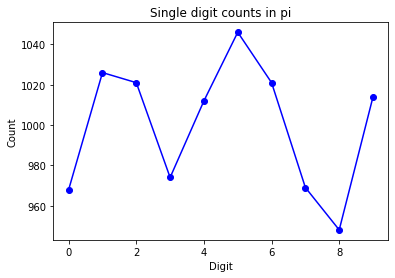

In [9]:
pi = sympy.pi.evalf(10000)
digits = (d for d in str(pi)[2:])  # create a sequence of digits
freqs = one_digit_freqs(digits)
plot_one_digit_freqs(freqs)

In [ ]:
from IPython.parallel import Client

# The Client allows us to use the engines interactively.
# We simply pass Client the name of the cluster profile we
# are using.
In [2]: c = Client(profile='mycluster')
In [3]: v = c[:]

In [3]: c.ids
In [5]: filestring = 'pi200m.ascii.%(i)02dof20'

# Create the list of files to process.
In [6]: files = [filestring % {'i':i} for i in range(1,16)]


# download the data files if they don't already exist:
In [8]: v.map(fetch_pi_file, files)

# This is the parallel calculation using the Client.map method
# which applies compute_two_digit_freqs to each file in files in parallel.
In [9]: freqs_all = v.map(compute_two_digit_freqs, files)

# Add up the frequencies from each engine.
In [10]: freqs = reduce_freqs(freqs_all)

In [11]: plot_two_digit_freqs(freqs)

In [12]: plt.title('2 digit counts of 150m digits of pi')

<img src="http://ipython.org/ipython-doc/dev/_images/two_digit_counts.png">